In [1]:
import mdp
import numpy as np
import matplotlib.pyplot as plt

### GridWorld using Value Iteration: In this example, we will use value iteration to obtain the Q/value -function for the GridWorld problem and extract a policy

In [2]:
# instantiate grid world mdp object
gw = mdp.GridWorld(discount_factor=0.9)

# instantaiate Q table
Q = mdp.QTable(gw)


In [3]:
# run value iteration
mdp.value_iteration(gw, Q, num_iters=100)

# policy extraction
pi = Q.extract_policy(gw)

print("-----------------------")
for y in range(gw.height-1, -1, -1):
    for x in range(gw.width):
        if (x,y) in pi:
            print(f"{pi[(x,y)]:<6}", end=' ')
        else:
            print(f"{'None':<6}", end=' ')
    print("")       
print("-----------------------")

Iteration# 0
-----------------------
 0.00  0.00  0.00  1.00 
 0.00  0.00  0.00 -1.00 
 0.00  0.00  0.00  0.00 
-----------------------
Iteration# 1
-----------------------
 0.00  0.00  0.72  1.00 
 0.00  0.00  0.00 -1.00 
 0.00  0.00  0.00  0.00 
-----------------------
Iteration# 2
-----------------------
 0.00  0.52  0.78  1.00 
 0.00  0.00  0.43 -1.00 
 0.00  0.00  0.00  0.00 
-----------------------
Iteration# 3
-----------------------
 0.37  0.66  0.83  1.00 
 0.00  0.00  0.51 -1.00 
 0.00  0.00  0.31  0.00 
-----------------------
Iteration# 4
-----------------------
 0.51  0.72  0.84  1.00 
 0.27  0.00  0.55 -1.00 
 0.00  0.22  0.37  0.13 
-----------------------
Iteration# 5
-----------------------
 0.59  0.73  0.85  1.00 
 0.41  0.00  0.57 -1.00 
 0.21  0.31  0.43  0.19 
-----------------------
Iteration# 6
-----------------------
 0.62  0.74  0.85  1.00 
 0.50  0.00  0.57 -1.00 
 0.34  0.36  0.45  0.24 
-----------------------
Iteration# 7
-----------------------
 0.63  0.74

### Q-Learning/SARSA: For model free MDPs, we cxannot use value iteration. Instead, we can bootstrap from an estimate of the value function to update Q values. 

In [4]:
def moving_average(x, window_size):
    smoothed_x = []
    for i in range(len(x)):
        lo = max(0, i-window_size+1)
        windowed = x[lo:i+1]
        avg = sum(windowed) / len(windowed)
        smoothed_x.append(avg)
    return smoothed_x

def plot_rewards(rewards, smoothing=True, window_size=10):
    fig = plt.figure(figsize=(5, 5))
    if smoothing:
        plt.plot(moving_average(rewards, window_size))
    else:
        plt.plot(rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Accumulated Reward")
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.show()

Episode# 0, length: 17, accumulated reward: 0.18530201888518416
-----------------------
 0.00  0.00  0.00  0.30 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 1, length: 61, accumulated reward: 0.001797010299914434
-----------------------
 0.00  0.00  0.08  0.51 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 2, length: 16, accumulated reward: 0.20589113209464907
-----------------------
 0.00  0.02  0.19  0.66 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 3, length: 34, accumulated reward: 0.030903154382632636
-----------------------
 0.01  0.05  0.27  0.76 
 0.00  0.00  0.04  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 4, length: 14, accumulated reward: 0.2541865828329001
-----------------------
 0.01  0.12  0.32  0.83 
 0.00  0.00  0.08  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 5, length: 8, accumulated reward: -0.4782969000000001
-

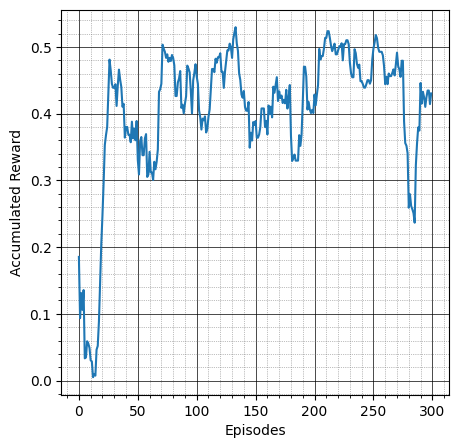

In [5]:
# instantiate grid world mdp object
gw2 = mdp.GridWorld(discount_factor=0.9)


# instantaiate Q table
Q2 = mdp.QTable(gw2)

# instantiate Q learner
QL = mdp.QLearner(gw2, Q2, alpha=0.3)


# training
episode_rewards = QL.train(episodes=300)

# policy extraction
pi = Q2.extract_policy(gw2)

print("-----------------------")
for y in range(gw2.height-1, -1, -1):
    for x in range(gw2.width):
        if (x,y) in pi:
            print(f"{pi[(x,y)]:<6}", end=' ')
        else:
            print(f"{'None':<6}", end=' ')
    print("")       
print("-----------------------")

plot_rewards(episode_rewards)


Episode# 0, length: 76, accumulated reward: 0.00036998848503512764
-----------------------
 0.00  0.00  0.00  0.30 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 1, length: 49, accumulated reward: 0.00636268544113595
-----------------------
 0.00  0.00  0.08  0.51 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 2, length: 35, accumulated reward: 0.027812838944369374
-----------------------
 0.00  0.02  0.19  0.66 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 3, length: 30, accumulated reward: 0.047101286972462485
-----------------------
 0.00  0.05  0.31  0.76 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 4, length: 16, accumulated reward: 0.20589113209464907
-----------------------
 0.01  0.13  0.35  0.83 
 0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
Episode# 5, length: 19, accumulated reward: 0.15009463529699

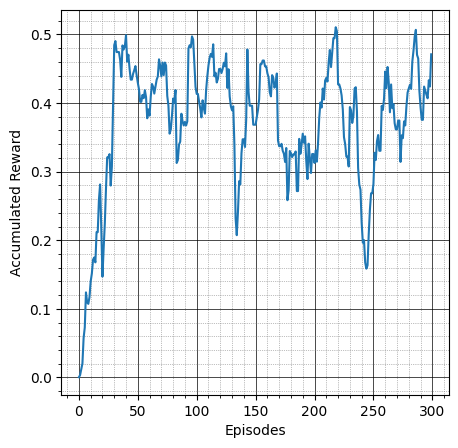

In [6]:
# instantiate grid world mdp object
gw3 = mdp.GridWorld(discount_factor=0.9)

# instantaiate Q table
Q3 = mdp.QTable(gw2)

# instantiate Q learner
QL2 = mdp.QLearner(gw3, Q3, alpha=0.3)

# training
episode_rewards = QL2.train(episodes=300, SARSA=True)

# policy extraction
pi = Q3.extract_policy(gw3)

print("-----------------------")
for y in range(gw3.height-1, -1, -1):
    for x in range(gw3.width):
        if (x,y) in pi:
            print(f"{pi[(x,y)]:<6}", end=' ')
        else:
            print(f"{'None':<6}", end=' ')
    print("")       
print("-----------------------")

plot_rewards(episode_rewards)

## Testing Q learning and SARSA on the CliffWorld problem

#### Obtaining Cliffworld policy using value iteration (Note that we're using a deterministic model here, so no transition noise)

In [7]:
# instantiate cliff world mdp object
cw1 = mdp.CliffWorld(discount_factor=0.9, noise=0.0)

# instantaiate Q table
Q = mdp.QTable(cw1)

mdp.value_iteration(cw1, Q, num_iters=100, theta=0.01)

# policy extraction
pi1 = Q.extract_policy(cw1)

print("-----------------------")
for y in range(cw1.height-1, -1, -1):
    for x in range(cw1.width):
        if (x,y) in pi1:
            print(f"{pi1[(x,y)]:<6}", end=' ')
        else:
            print(f"{'None':<6}", end=' ')
    print("")       
print("-----------------------")

Iteration# 0
-----------------------
-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 
-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 
-0.05 -0.05 -0.05 -0.05 -0.05  0.00 
-0.05  0.00  0.00  0.00  0.00  0.00 
-----------------------
Iteration# 1
-----------------------
-0.10 -0.10 -0.10 -0.10 -0.10 -0.10 
-0.10 -0.10 -0.10 -0.10 -0.10 -0.05 
-0.10 -0.10 -0.10 -0.10 -0.05  0.00 
-0.10  0.00  0.00  0.00  0.00  0.00 
-----------------------
Iteration# 2
-----------------------
-0.14 -0.14 -0.14 -0.14 -0.14 -0.10 
-0.14 -0.14 -0.14 -0.14 -0.10 -0.05 
-0.14 -0.14 -0.14 -0.10 -0.05  0.00 
-0.14  0.00  0.00  0.00  0.00  0.00 
-----------------------
Iteration# 3
-----------------------
-0.17 -0.17 -0.17 -0.17 -0.14 -0.10 
-0.17 -0.17 -0.17 -0.14 -0.10 -0.05 
-0.17 -0.17 -0.14 -0.10 -0.05  0.00 
-0.17  0.00  0.00  0.00  0.00  0.00 
-----------------------
Iteration# 4
-----------------------
-0.20 -0.20 -0.20 -0.17 -0.14 -0.10 
-0.20 -0.20 -0.17 -0.14 -0.10 -0.05 
-0.20 -0.17 -0.14 -0.10 -0.05  0.00 
-0.20  0.00  0.0

#### Obtaining Cliffworld policy using Q learning

Episode# 0, length: 41, accumulated reward: -0.5739044147071732
-----------------------
 0.00  0.00 -0.01  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 1, length: 2, accumulated reward: -5.0
-----------------------
 0.00  0.00 -0.01  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 2, length: 12, accumulated reward: -2.0690529804500004
-----------------------
 0.00  0.00 -0.01  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 3, length: 8, accumulated reward: -2.8914845000000002
-----------------------
 0.00  0.00 -0.01  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.02  0.00  0.00  0.00  0.00  0.00 
-

Episode# 48, length: 38, accumulated reward: -0.4887358002275306
-----------------------
-0.10 -0.10 -0.09 -0.07 -0.06 -0.05 
-0.11 -0.10 -0.09 -0.07 -0.06 -0.04 
-0.13 -0.10 -0.08 -0.07 -0.04  0.00 
-0.15  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 49, length: 2, accumulated reward: -5.0
-----------------------
-0.10 -0.10 -0.09 -0.07 -0.06 -0.05 
-0.11 -0.10 -0.09 -0.07 -0.06 -0.04 
-0.13 -0.10 -0.08 -0.07 -0.04  0.00 
-0.15  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 50, length: 36, accumulated reward: -0.4860935805278155
-----------------------
-0.10 -0.10 -0.09 -0.07 -0.06 -0.05 
-0.11 -0.10 -0.09 -0.07 -0.06 -0.04 
-0.13 -0.11 -0.09 -0.07 -0.04  0.00 
-0.15  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 51, length: 23, accumulated reward: -0.4452905054342439
-----------------------
-0.11 -0.10 -0.09 -0.07 -0.06 -0.05 
-0.11 -0.10 -0.09 -0.07 -0.06 -0.04 
-0.13 -0.11 -0.09 -0.07 -0.04  0.00 
-0.15  0.00  0.00  0.00  0.00  0.

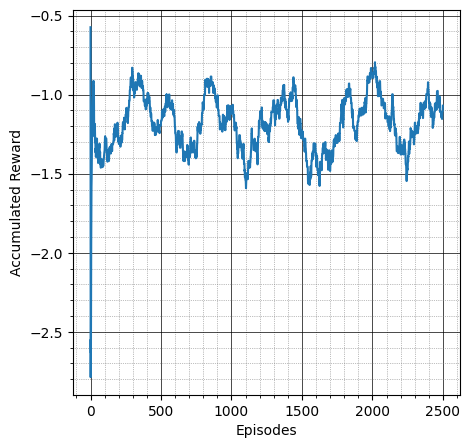

In [8]:
# intantiate cliffworld object
cw2 = mdp.CliffWorld(discount_factor=0.9, noise=0.0)

# instantaiate Q table
Q2 = mdp.QTable(cw2)

# instantiate Q learner
QL1 = mdp.QLearner(cw2, Q2, epsilon=0.2, alpha=0.1)

# training
episode_rewards = QL1.train(episodes=2500, SARSA=False)

# policy extraction
pi1 = Q2.extract_policy(cw2)

print("-----------------------")
for y in range(cw2.height-1, -1, -1):
    for x in range(cw2.width):
        if (x,y) in pi1:
            print(f"{pi1[(x,y)]:<6}", end=' ')
        else:
            print(f"{'None':<6}", end=' ')
    print("")       
print("-----------------------")

plot_rewards(episode_rewards, window_size=100)

#### Obtaining Cliffworld policy using SARSA

Episode# 0, length: 15, accumulated reward: -1.6438396227480503
-----------------------
 0.00  0.00  0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00  0.00  0.00 
 0.00  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 1, length: 31, accumulated reward: -0.7119557913760813
-----------------------
-0.01 -0.01  0.00  0.00  0.00  0.00 
-0.01 -0.01  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 2, length: 11, accumulated reward: -2.2433922005000007
-----------------------
-0.01 -0.01  0.00  0.00  0.00  0.00 
-0.01 -0.01  0.00  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.02  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 3, length: 49, accumulated reward: -0.5318134272056799
-----------------------
-0.01 -0.01 -0.01 -0.01  0.00  0.00 
-0.01 -0.01 -0.01  0.00  0.00  0.00 
-0.01  0.00  0.00  0.00  0.00  0.00 
-0.02  0.00  0.00  0.

Episode# 129, length: 18, accumulated reward: -0.40734899055740803
-----------------------
-0.22 -0.20 -0.17 -0.15 -0.12 -0.10 
-0.23 -0.20 -0.17 -0.13 -0.10 -0.05 
-0.25 -0.14 -0.13 -0.11 -0.05  0.00 
-0.29  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 130, length: 9, accumulated reward: -0.26085155000000004
-----------------------
-0.22 -0.20 -0.17 -0.15 -0.12 -0.10 
-0.23 -0.20 -0.17 -0.13 -0.10 -0.05 
-0.25 -0.14 -0.13 -0.11 -0.05  0.00 
-0.30  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 131, length: 3, accumulated reward: -4.55
-----------------------
-0.22 -0.20 -0.17 -0.15 -0.12 -0.10 
-0.23 -0.20 -0.17 -0.13 -0.10 -0.05 
-0.25 -0.14 -0.13 -0.11 -0.05  0.00 
-0.30  0.00  0.00  0.00  0.00  0.00 
-----------------------
Episode# 132, length: 2, accumulated reward: -5.0
-----------------------
-0.22 -0.20 -0.17 -0.15 -0.12 -0.10 
-0.23 -0.20 -0.17 -0.13 -0.10 -0.05 
-0.25 -0.14 -0.13 -0.11 -0.05  0.00 
-0.30  0.00  0.00  0.00  0.00  0.00 
------

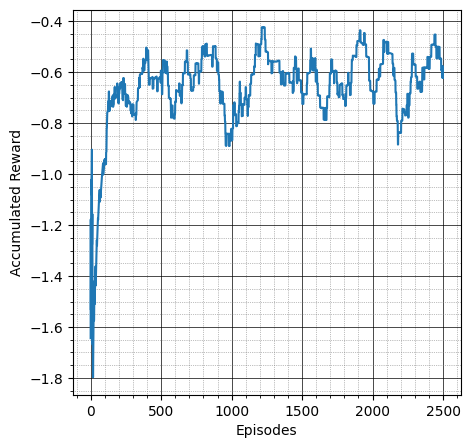

In [9]:
cw3 = mdp.CliffWorld(discount_factor=0.9, noise=0.0)

# instantaiate Q table
Q3 = mdp.QTable(cw2)

# instantiate Q learner
QL2 = mdp.QLearner(cw3, Q3, epsilon=0.2, alpha=0.1)

# training
episode_rewards = QL2.train(episodes=2500, SARSA=True)

# policy extraction
pi2 = Q3.extract_policy(cw3)

print("-----------------------")
for y in range(cw3.height-1, -1, -1):
    for x in range(cw3.width):
        if (x,y) in pi2:
            print(f"{pi2[(x,y)]:<6}", end=' ')
        else:
            print(f"{'None':<6}", end=' ')
    print("")       
print("-----------------------")

plot_rewards(episode_rewards, window_size=100)